In [2]:
import pandas as pd
from datetime import datetime
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Bidirectional
from tensorflow.keras import activations
import matplotlib.pyplot as plt

import numpy as np
import time

from keras.layers import LSTM, Dense, Bidirectional, Input,Dropout,BatchNormalization, CuDNNGRU, CuDNNLSTM, Flatten


In [3]:
df = pd.read_csv("data/allMonsoon_delhi.csv")
df['From Date'] = df['Datetime']

df = df[['From Date','O3','Temperature','SO2','PM10','NO2','CO']] # new features : 6
df = df.replace(to_replace='None', value=np.nan)
df = df.dropna(axis = 0, how = 'all')
df['SO2'].fillna(df['SO2'].median(), inplace=True)

df = df.set_index('From Date')
df = df.iloc[::3, :]
df.to_csv('data1.csv')
print(df.columns)

print(" \nCount total NaN at each column in a DataFrame : \n\n", df.isnull().sum())

Index(['O3', 'Temperature', 'SO2', 'PM10', 'NO2', 'CO'], dtype='object')
 
Count total NaN at each column in a DataFrame : 

 O3             0
Temperature    0
SO2            0
PM10           0
NO2            0
CO             0
dtype: int64


In [4]:
# print(df)
dataset = read_csv('data1.csv', index_col=0)
dataset.columns = ['O3','Temperature','SO2','PM10','NO2','CO']
dataset.index.name = 'From Date'
# dataset['pollution'].fillna(0, inplace=True)
dataset = dataset[24:]
print("||"*40)
print("** DATA PROCESSING COMPLETED **")
print(dataset.head(5))
print("||"*40)
dataset.to_csv('pollution1.csv')

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
** DATA PROCESSING COMPLETED **
                        O3  Temperature   SO2    PM10    NO2     CO
From Date                                                          
2015-06-04 0:00:00   39.92        79.20  5.38  160.54  51.51  10.72
2015-06-04 3:00:00   38.31        78.80  4.90  115.29  40.77   2.73
2015-06-04 6:00:00   52.12        79.35  6.72  147.62  61.07   2.52
2015-06-04 9:00:00   52.95        84.20  6.49  230.50  63.55   4.13
2015-06-04 12:00:00  67.21        93.20  3.49  303.41  65.71   1.68
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


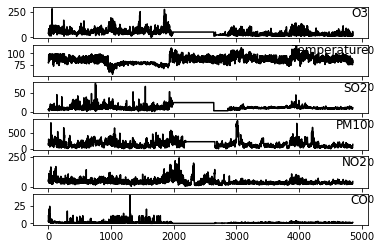

In [5]:
import pandas as pd
from matplotlib import pyplot

dataset = pd.read_csv('pollution1.csv', header=0, index_col=0)
values = dataset.values
groups = [0, 1, 2, 3, 4, 5]

i = 1
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group],'k')
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [6]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [7]:
from sklearn.preprocessing import RobustScaler
# try w different scaler
from IPython.display import display, HTML

# load dataset
dataset = read_csv('pollution1.csv', header=0, index_col=0)
# ensure all data is float
values = dataset.values
values = values.astype('float32')
scaler = RobustScaler()
scaled = scaler.fit_transform(values)
n_hours = 8
n_features = 6 # changed features from 5 to six
reframed = series_to_supervised(scaled, n_hours, 8)
print(reframed.shape)

(4841, 96)


TRIAL  0
(4841, 96)
(4100, 48) 4100 (4100,)
(4100, 8, 6) (4100,) (741, 8, 6) (741,)
Epoch 1/25
57/57 - 46s - loss: 0.6488 - val_loss: 0.2400
Epoch 2/25
57/57 - 12s - loss: 0.4402 - val_loss: 0.1833
Epoch 3/25
57/57 - 12s - loss: 0.4254 - val_loss: 0.1599
Epoch 4/25
57/57 - 13s - loss: 0.4120 - val_loss: 0.1530
Epoch 5/25
57/57 - 10s - loss: 0.4190 - val_loss: 0.1441
Epoch 6/25
57/57 - 9s - loss: 0.3950 - val_loss: 0.1435
Epoch 7/25
57/57 - 8s - loss: 0.4010 - val_loss: 0.1531
Epoch 8/25
57/57 - 9s - loss: 0.4004 - val_loss: 0.1435
Epoch 9/25
57/57 - 9s - loss: 0.3900 - val_loss: 0.1409
Epoch 10/25
57/57 - 10s - loss: 0.4317 - val_loss: 0.1659
Epoch 11/25
57/57 - 11s - loss: 0.3985 - val_loss: 0.1456
Epoch 12/25
57/57 - 11s - loss: 0.3920 - val_loss: 0.1392
Epoch 13/25
57/57 - 12s - loss: 0.3907 - val_loss: 0.1473
Epoch 14/25
57/57 - 11s - loss: 0.3849 - val_loss: 0.1487
Epoch 15/25
57/57 - 10s - loss: 0.3716 - val_loss: 0.1504
Epoch 16/25
57/57 - 9s - loss: 0.3720 - val_loss: 0.1613
Ep

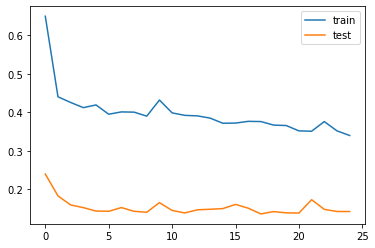

done | time taken: 308.722637 seconds
Test RMSE: 11.555
8.193904
0.4490746093032325
TRIAL  1
(4841, 96)
(4100, 48) 4100 (4100,)
(4100, 8, 6) (4100,) (741, 8, 6) (741,)
Epoch 1/25
57/57 - 26s - loss: 0.6547 - val_loss: 0.2390
Epoch 2/25
57/57 - 11s - loss: 0.4451 - val_loss: 0.1837
Epoch 3/25
57/57 - 9s - loss: 0.4317 - val_loss: 0.1591
Epoch 4/25
57/57 - 13s - loss: 0.4103 - val_loss: 0.1587
Epoch 5/25
57/57 - 15s - loss: 0.4030 - val_loss: 0.1434
Epoch 6/25
57/57 - 18s - loss: 0.4047 - val_loss: 0.1464
Epoch 7/25
57/57 - 18s - loss: 0.4039 - val_loss: 0.1458
Epoch 8/25
57/57 - 17s - loss: 0.4005 - val_loss: 0.1535
Epoch 9/25
57/57 - 12s - loss: 0.4029 - val_loss: 0.1637
Epoch 10/25
57/57 - 10s - loss: 0.4027 - val_loss: 0.1499
Epoch 11/25
57/57 - 11s - loss: 0.3909 - val_loss: 0.1657
Epoch 12/25
57/57 - 11s - loss: 0.3921 - val_loss: 0.1341
Epoch 13/25
57/57 - 12s - loss: 0.3964 - val_loss: 0.1367
Epoch 14/25
57/57 - 12s - loss: 0.3833 - val_loss: 0.1357
Epoch 15/25
57/57 - 12s - loss

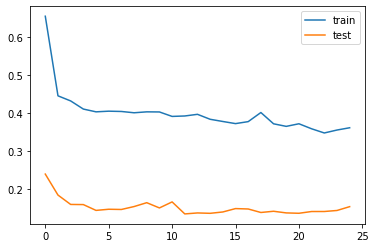

done | time taken: 343.783200 seconds
Test RMSE: 11.965
8.281793
0.40921544587718983
TRIAL  2
(4841, 96)
(4100, 48) 4100 (4100,)
(4100, 8, 6) (4100,) (741, 8, 6) (741,)
Epoch 1/25
57/57 - 24s - loss: 0.6615 - val_loss: 0.2379
Epoch 2/25
57/57 - 8s - loss: 0.4528 - val_loss: 0.1817
Epoch 3/25
57/57 - 8s - loss: 0.4349 - val_loss: 0.1573
Epoch 4/25
57/57 - 10s - loss: 0.4083 - val_loss: 0.1577
Epoch 5/25
57/57 - 10s - loss: 0.4140 - val_loss: 0.1410
Epoch 6/25
57/57 - 9s - loss: 0.4065 - val_loss: 0.1487
Epoch 7/25
57/57 - 9s - loss: 0.3940 - val_loss: 0.1434
Epoch 8/25
57/57 - 11s - loss: 0.4014 - val_loss: 0.1434
Epoch 9/25
57/57 - 10s - loss: 0.4018 - val_loss: 0.1449
Epoch 10/25
57/57 - 12s - loss: 0.4063 - val_loss: 0.1484
Epoch 11/25
57/57 - 10s - loss: 0.3907 - val_loss: 0.1510
Epoch 12/25
57/57 - 11s - loss: 0.3792 - val_loss: 0.1356
Epoch 13/25
57/57 - 13s - loss: 0.3782 - val_loss: 0.1383
Epoch 14/25
57/57 - 10s - loss: 0.3801 - val_loss: 0.1406
Epoch 15/25
57/57 - 9s - loss: 0

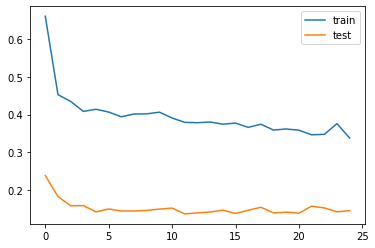

done | time taken: 291.745791 seconds
Test RMSE: 11.611
8.396658
0.4436830310767892
TRIAL  3
(4841, 96)
(4100, 48) 4100 (4100,)
(4100, 8, 6) (4100,) (741, 8, 6) (741,)
Epoch 1/25
57/57 - 37s - loss: 0.6218 - val_loss: 0.2465
Epoch 2/25
57/57 - 9s - loss: 0.4501 - val_loss: 0.1865
Epoch 3/25
57/57 - 10s - loss: 0.4414 - val_loss: 0.1701
Epoch 4/25
57/57 - 12s - loss: 0.4188 - val_loss: 0.1591
Epoch 5/25
57/57 - 13s - loss: 0.4162 - val_loss: 0.1512
Epoch 6/25
57/57 - 12s - loss: 0.4089 - val_loss: 0.1515
Epoch 7/25
57/57 - 12s - loss: 0.3978 - val_loss: 0.1528
Epoch 8/25
57/57 - 11s - loss: 0.4077 - val_loss: 0.1448
Epoch 9/25
57/57 - 10s - loss: 0.3981 - val_loss: 0.1526
Epoch 10/25
57/57 - 11s - loss: 0.3908 - val_loss: 0.1565
Epoch 11/25
57/57 - 13s - loss: 0.3846 - val_loss: 0.1723
Epoch 12/25
57/57 - 11s - loss: 0.3842 - val_loss: 0.1426
Epoch 13/25
57/57 - 14s - loss: 0.3930 - val_loss: 0.1449
Epoch 14/25
57/57 - 14s - loss: 0.3700 - val_loss: 0.1386
Epoch 15/25
57/57 - 14s - loss

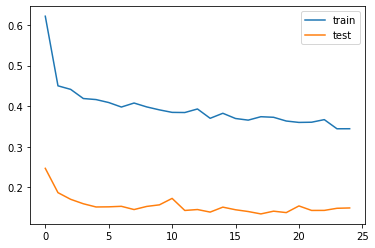

done | time taken: 450.839992 seconds
Test RMSE: 11.791
8.261483
0.4263422146373158
TRIAL  4
(4841, 96)
(4100, 48) 4100 (4100,)
(4100, 8, 6) (4100,) (741, 8, 6) (741,)
Epoch 1/25
57/57 - 141s - loss: 0.6782 - val_loss: 0.2380
Epoch 2/25
57/57 - 20s - loss: 0.4605 - val_loss: 0.1832
Epoch 3/25
57/57 - 17s - loss: 0.4225 - val_loss: 0.1589
Epoch 4/25
57/57 - 18s - loss: 0.4142 - val_loss: 0.1488
Epoch 5/25
57/57 - 17s - loss: 0.4036 - val_loss: 0.1465
Epoch 6/25
57/57 - 17s - loss: 0.3987 - val_loss: 0.1453
Epoch 7/25
57/57 - 17s - loss: 0.3928 - val_loss: 0.1505
Epoch 8/25
57/57 - 19s - loss: 0.3838 - val_loss: 0.1429
Epoch 9/25
57/57 - 18s - loss: 0.3874 - val_loss: 0.1438
Epoch 10/25
57/57 - 19s - loss: 0.3955 - val_loss: 0.1705
Epoch 11/25
57/57 - 22s - loss: 0.3941 - val_loss: 0.1415
Epoch 12/25
57/57 - 28s - loss: 0.4132 - val_loss: 0.1444
Epoch 13/25
57/57 - 18s - loss: 0.3828 - val_loss: 0.1387
Epoch 14/25
57/57 - 27s - loss: 0.3822 - val_loss: 0.1403
Epoch 15/25
57/57 - 25s - lo

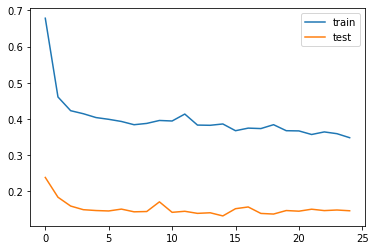

done | time taken: 789.774582 seconds
Test RMSE: 11.674
8.400093
0.43767758167925075
TRIAL  5
(4841, 96)
(4100, 48) 4100 (4100,)
(4100, 8, 6) (4100,) (741, 8, 6) (741,)
Epoch 1/25
57/57 - 111s - loss: 0.6591 - val_loss: 0.2360
Epoch 2/25
57/57 - 25s - loss: 0.4560 - val_loss: 0.1825
Epoch 3/25
57/57 - 26s - loss: 0.4249 - val_loss: 0.1572
Epoch 4/25
57/57 - 26s - loss: 0.4115 - val_loss: 0.1589
Epoch 5/25
57/57 - 25s - loss: 0.4191 - val_loss: 0.1490
Epoch 6/25
57/57 - 24s - loss: 0.4043 - val_loss: 0.1446
Epoch 7/25
57/57 - 26s - loss: 0.3982 - val_loss: 0.1471
Epoch 8/25
57/57 - 20s - loss: 0.4027 - val_loss: 0.1449
Epoch 9/25
57/57 - 21s - loss: 0.4032 - val_loss: 0.1417
Epoch 10/25
57/57 - 21s - loss: 0.4117 - val_loss: 0.1362
Epoch 11/25
57/57 - 19s - loss: 0.3868 - val_loss: 0.1465
Epoch 12/25
57/57 - 21s - loss: 0.3820 - val_loss: 0.1357
Epoch 13/25
57/57 - 27s - loss: 0.3805 - val_loss: 0.1341
Epoch 14/25
57/57 - 23s - loss: 0.3752 - val_loss: 0.1392
Epoch 15/25
57/57 - 19s - l

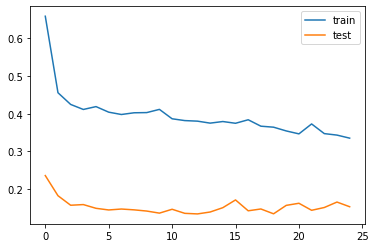

done | time taken: 664.774988 seconds
Test RMSE: 11.965
8.305889
0.40925352313705166
TRIAL  6
(4841, 96)
(4100, 48) 4100 (4100,)
(4100, 8, 6) (4100,) (741, 8, 6) (741,)
Epoch 1/25
57/57 - 207s - loss: 0.6492 - val_loss: 0.2398
Epoch 2/25
57/57 - 27s - loss: 0.4529 - val_loss: 0.1821
Epoch 3/25
57/57 - 23s - loss: 0.4376 - val_loss: 0.1589
Epoch 4/25
57/57 - 20s - loss: 0.4047 - val_loss: 0.1527
Epoch 5/25
57/57 - 21s - loss: 0.4185 - val_loss: 0.1406
Epoch 6/25
57/57 - 24s - loss: 0.3992 - val_loss: 0.1393
Epoch 7/25
57/57 - 24s - loss: 0.3906 - val_loss: 0.1395
Epoch 8/25
57/57 - 24s - loss: 0.3984 - val_loss: 0.1591
Epoch 9/25
57/57 - 26s - loss: 0.3942 - val_loss: 0.1444
Epoch 10/25
57/57 - 20s - loss: 0.3948 - val_loss: 0.1485
Epoch 11/25
57/57 - 19s - loss: 0.3845 - val_loss: 0.1589
Epoch 12/25
57/57 - 25s - loss: 0.4146 - val_loss: 0.1406
Epoch 13/25
57/57 - 18s - loss: 0.3897 - val_loss: 0.1370
Epoch 14/25
57/57 - 24s - loss: 0.3826 - val_loss: 0.1337
Epoch 15/25
57/57 - 19s - l

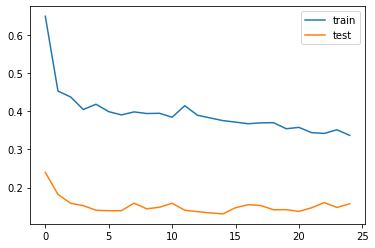

done | time taken: 902.088717 seconds
Test RMSE: 12.136
8.428471
0.3922799495896455


In [17]:
rmses = []
maes = []
rsquared = []
times = []

from tensorflow.keras.callbacks import EarlyStopping

# early_stopping = EarlyStopping(
#     min_delta=0.001, # minimium amount of change to count as an improvement
#     patience=20, # how many epochs to wait before stopping
#     restore_best_weights=True,
# )

from sklearn.preprocessing import RobustScaler
# try w different scaler
from IPython.display import display, HTML


for z in range(7):
    t0 = time.time()
    print('TRIAL ', z)
    # load dataset
    dataset = read_csv('pollution1.csv', header=0, index_col=0)
    # dataset = dataset[2000:6000]
    # ensure all data is float
    values = dataset.values
    values = values.astype('float32')
    scaler = RobustScaler()
    scaled = scaler.fit_transform(values)
    n_hours = 8
    n_features = 6 # changed features from 5 to six
    reframed = series_to_supervised(scaled, n_hours, 8)
    print(reframed.shape)


    # split into train and test sets
    values = reframed.values
    n_train_hours = 4100
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]

    # split into input and outputs
    n_obs = n_hours * n_features
    train_X = train[:, :n_obs]
    train_y = train[:, -n_features]
    test_X = test[:, :n_obs]
    test_y = test[:, -n_features]
    
    print(train_X.shape, len(train_X), train_y.shape)
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
    test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

    n_out = 1
    #######


    # Building the model
    model = Sequential()
    # Adding a Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(256,return_sequences=True, dropout=0.2, input_shape=(n_hours,n_features)))) # change number of neurons to 256, 128
    model.add(Bidirectional(LSTM(128, dropout=0.2)))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')


    ########## ^ normal
    # model = Sequential()
    # model.add(Bidirectional(LSTM(64, activation='selu', return_sequences=True), input_shape=(n_hours, n_features)))
    # model.add(Bidirectional(LSTM(64, activation='selu', return_sequences=True)))
    # model.add(Bidirectional(LSTM(50, activation='selu')))
    # model.add(Dense(1))
    # model.compile(optimizer='adam', loss='mse', metrics=['mean_squared_error'])
    #####

    history = model.fit(train_X, train_y, epochs=25, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False) # try combo


    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X[:, -5:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat) #################
    inv_yhat = inv_yhat[:,0]

    # invert scaling for actual
    from sklearn.metrics import mean_absolute_error, r2_score

    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, -5:]), axis=1) # changed from -7 to -11 to -5 # because it is n_features-1. also had really good results for -11?
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    mae = (mean_absolute_error(inv_y, inv_yhat))
    r2 = (r2_score(inv_y, inv_yhat))



    t1 = time.time()


    total = t1-t0

    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()

    print("done | time taken: %f seconds" %total)
    print('Test RMSE: %.3f' % rmse)
    print(mae)
    print(r2)
    
    maes.append(mae)
    rmses.append(rmse)
    rsquared.append(r2)
    times.append(total)
#print(mae)

In [18]:
mymae = [round(x, 2) for x in maes]
myrmse = [round(x, 2) for x in rmses]
myrsquared = [round(x, 2) for x in rsquared]
mytime = [round(x, 2) for x in times]

print(mymae)
print(myrmse)
print(myrsquared)
print(mytime)

[8.19, 8.28, 8.4, 8.26, 8.4, 8.31, 8.43]
[11.55, 11.97, 11.61, 11.79, 11.67, 11.96, 12.14]
[0.45, 0.41, 0.44, 0.43, 0.44, 0.41, 0.39]
[308.72, 343.78, 291.75, 450.84, 789.77, 664.77, 902.09]


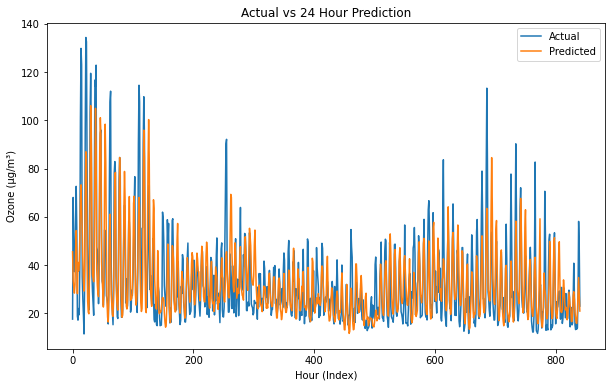

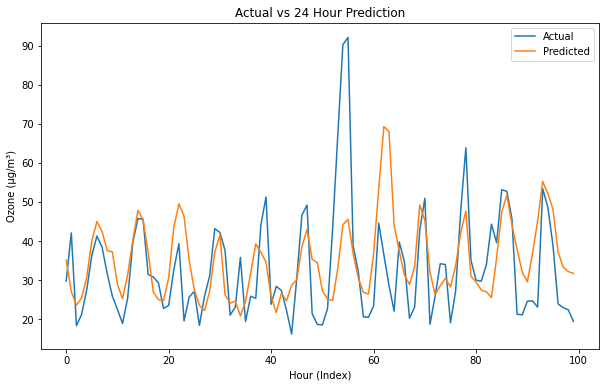

In [10]:
### plots

# entire thing

actual = inv_y
pred2 = inv_yhat
plt.figure(figsize=(10,6))
plt.plot( list(actual))
plt.plot( list(pred2))
plt.title("Actual vs 24 Hour Prediction")
plt.ylabel('Ozone (µg/m³)')
plt.xlabel("Hour (Index)")
plt.legend(('Actual','Predicted'))
plt.show()

# sample

actual = inv_y[200:300]
pred2 = inv_yhat[200:300]
plt.figure(figsize=(10,6))
plt.plot( list(actual))
plt.plot( list(pred2))
plt.title("Actual vs 24 Hour Prediction")
plt.ylabel('Ozone (µg/m³)')
plt.xlabel("Hour (Index)")
plt.legend(('Actual','Predicted'))
plt.show()

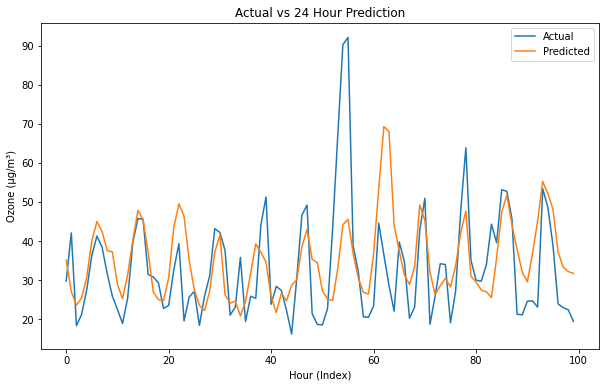

In [11]:
sample = (dataset['O3'][2200:2400])

actual = inv_y[200:300]
pred2 = inv_yhat[200:300]
plt.figure(figsize=(10,6))
plt.plot( list(actual))
plt.plot( list(pred2))
plt.title("Actual vs 24 Hour Prediction")
plt.ylabel('Ozone (µg/m³)')
plt.xlabel("Hour (Index)")
plt.legend(('Actual','Predicted'))
plt.show()

In [14]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
mae = (mean_absolute_error(inv_y, inv_yhat))

print(rmse, mae)

12.904380681438546 8.789605
